In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
from google.colab import files
uploaded = files.upload()

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Saving TrainingData.csv to TrainingData.csv
Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%   

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

print("Shape of X:\n",X.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X = X.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%       

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

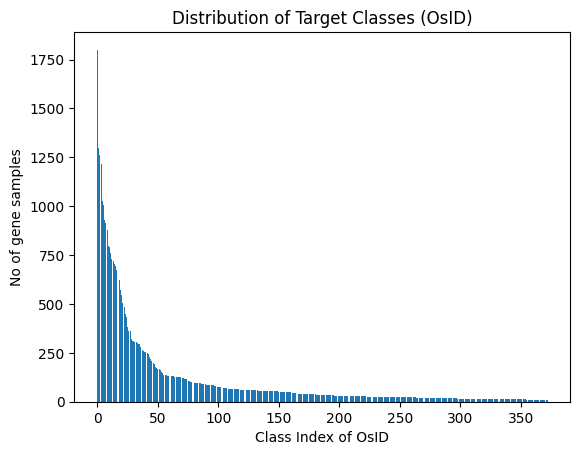

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model():

    model = Sequential()
    model.add(Dense(60, input_dim=20,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the training, validation and test accuracy and loss of each fold
train_accuracy = []
train_loss = []
val_accuracy = []
val_loss = []
test_accuracy = []
models = []
hist = []

# Loop over the folds
for fold, (train_index, val_index) in enumerate(cv_method.split(X_train, y_train)):
    print("Fold:", fold+1)

    # Split the data into train and validation sets using the current fold index
    X_train_fold  = X_train[train_index]
    y_train_fold  = y_train[train_index]
    X_val_fold = X_train[val_index]
    y_val_fold = y_train[val_index]

    # Prepare the target data
    y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

    # Build the model
    model = MLP_model()

    # Fit the model to the training data for the current fold
    history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=80, batch_size=5, verbose=1, validation_split = 0.33)
    
    # Evaluate the model on the validation data for the current fold
    val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
    val_accuracy.append(val_scores[1])
    val_loss.append(val_scores[0])

    # Evaluate the model on the test data for the current fold
    test_scores = model.evaluate(X_test, to_categorical(y_test_enc, num_classes=373), verbose=0)
    test_accuracy.append(test_scores[1])

    # add the model to the list of models
    models.append(model)
    hist.append(history)

    # store the training accuracy and loss for each fold
    train_accuracy.append(history.history['accuracy'])
    train_loss.append(history.history['loss'])
      
    # Print the test and validation accuracy and loss for the current fold
    print("Validation Accuracy:", val_scores[1])
    print("Validation Loss:", val_scores[0])
    print("Test Accuracy:", test_scores[1])
    print("Test Loss:", test_scores[0])

        
# Calculate the average test and validation accuracy and loss across all folds
avg_test_acc = sum(test_accuracy) / len(test_accuracy)
avg_val_acc = sum(val_accuracy) / len(val_accuracy)
avg_val_loss = sum(val_loss) / len(val_loss)

# Print the average validation and test accuracy and loss
print("Average Validation Accuracy:", avg_val_acc)
print("Average Validation Loss:",avg_val_loss)
print("Average Test Accuracy:", avg_test_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

Fold: 1
Epoch 1/80
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2732 - accuracy: 0.3916 - val_loss: 2.0682 - val_accuracy: 0.6440
Epoch 2/80
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2609 - accuracy: 0.7708 - val_loss: 1.1165 - val_accuracy: 0.8154
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6926 - accuracy: 0.8603 - val_loss: 0.7877 - val_accuracy: 0.8678
Epoch 4/80
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4639 - accuracy: 0.9004 - val_loss: 0.6240 - val_accuracy: 0.8944
Epoch 5/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3456 - accuracy: 0.9216 - val_loss: 0.5500 - val_accuracy: 0.9030
Epoch 6/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2795 - accuracy: 0.9325 - val_loss: 0.4997 - val_accuracy: 0.9175
Epoch 7/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.2363 - accuracy: 0.9432 - val_loss: 0.4318 - val_a

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 3.4218 - accuracy: 0.3716 - val_loss: 2.1622 - val_accuracy: 0.6420
Epoch 2/80
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2644 - accuracy: 0.7609 - val_loss: 1.2723 - val_accuracy: 0.7652
Epoch 3/80
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6241 - accuracy: 0.8705 - val_loss: 0.7628 - val_accuracy: 0.8693
Epoch 4/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3982 - accuracy: 0.9134 - val_loss: 0.5810 - val_accuracy: 0.8988
Epoch 5/80
1846/1846 [==============================] - 5s 2ms/step - loss: 0.2993 - accuracy: 0.9297 - val_loss: 0.4424 - val_accuracy: 0.9274
Epoch 6/80
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2451 - accuracy: 0.9404 - val_loss: 0.3927 - val_accuracy: 0.9342
Epoch 7/80
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2098 - accuracy: 0.9465 - val_loss: 0.3412 - val_accuracy: 0.9380
Epo

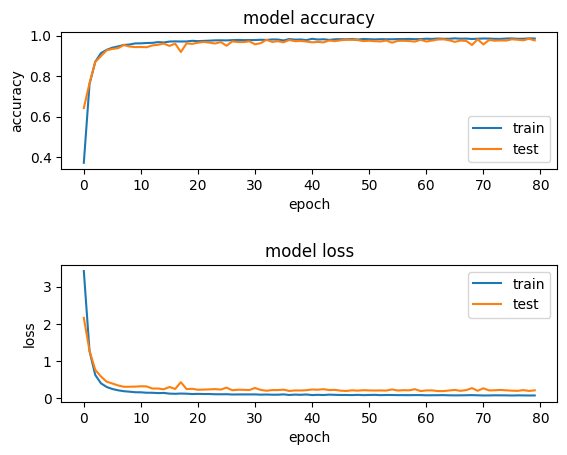

Final Test Accuracy: 0.9828259944915771


In [10]:
# Select the final model based on the average test accuracy across all folds
best_model_index = test_accuracy.index(max(test_accuracy))
best_model = models[best_model_index]
best_model_history = hist[best_model_index]
best_model_train_acc = train_accuracy[best_model_index]
best_model_train_loss = train_loss[best_model_index]
best_model_val_acc = val_accuracy[best_model_index]
best_model_val_loss = val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", test_accuracy[best_model_index])

In [11]:
# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       0.99      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.94      1.00      0.97       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       0.99      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


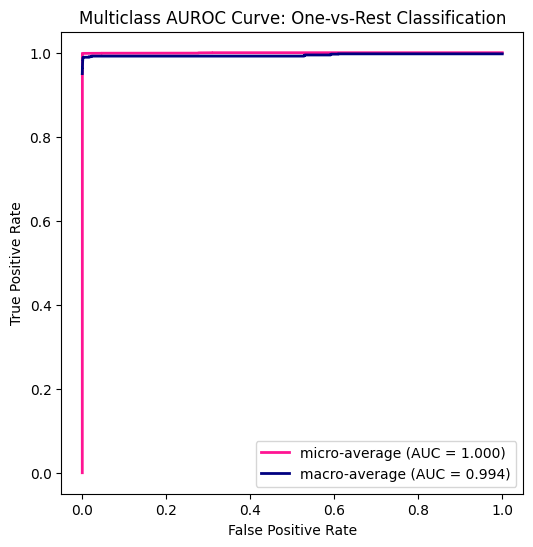

In [12]:
n_classes = 373
ohe_y_test_enc = to_categorical(y_test_enc, num_classes=373)

# Store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute ROC curve and ROC area for each class (one-vs-rest)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_y_test_enc[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ohe_y_test_enc.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
valid_classes = 0 
for i in range(n_classes):
    if np.sum(ohe_y_test_enc[:, i]) > 0:  # Exclude classes with no positive samples
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        valid_classes += 1

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plot all OvR ROC curves together
fig, ax = plt.subplots(figsize=(8, 6))



plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.3f})",
    color="deeppink",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.3f})",
    color="navy",
    linewidth=2,
)


plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass AUROC Curve: One-vs-Rest Classification")
plt.legend(loc="lower right")
plt.show()

In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              328        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True
